#Importing Data

In [452]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [453]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

In [454]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [455]:
!cd /content/drive/MyDrive/HJLS_Properties/Streeteasy

In [456]:
!pwd

/content


In [457]:
inventorystudio=pd.read_csv('/content/drive/MyDrive/HJLS_Properties/Streeteasy/rentalInventory_Studio.csv')
inventory1=pd.read_csv('/content/drive/MyDrive/HJLS_Properties/Streeteasy/rentalInventory_OneBd.csv')
inventory2=pd.read_csv('/content/drive/MyDrive/HJLS_Properties/Streeteasy/rentalInventory_TwoBd.csv')
inventory3=pd.read_csv('/content/drive/MyDrive/HJLS_Properties/Streeteasy/rentalInventory_ThreePlusBd.csv')

rentstudio=pd.read_csv('/content/drive/MyDrive/HJLS_Properties/Streeteasy/medianAskingRent_Studio.csv')
rent1=pd.read_csv('/content/drive/MyDrive/HJLS_Properties/Streeteasy/medianAskingRent_OneBd.csv')
rent2=pd.read_csv('/content/drive/MyDrive/HJLS_Properties/Streeteasy/medianAskingRent_TwoBd.csv')
rent3=pd.read_csv('/content/drive/MyDrive/HJLS_Properties/Streeteasy/medianAskingRent_ThreePlusBd.csv')

# Data Cleaning and Prep

## StreetEasy Data

### Preperation for merging 8 datasets

Filter for only neigherhoods and add feature of how many bedroom there is. There are in total 177 neighborhoods, however many has NaN values for some months or all months. 

Therefore we need to drop some neighborhoods and/or impute values

The data for rent and inventory goes back to Jan 2010, but we are only pulling data as this dataset is most complete and relevant to today. 
(If we have time we can also see if it will make a difference if we use from longer ago)

In [458]:
rentstudio = rentstudio[rentstudio.areaType=='neighborhood']
rent1 = rent1[rent1.areaType == 'neighborhood']
rent2 = rent2[rent2.areaType == 'neighborhood']
rent3 = rent3[rent3.areaType == 'neighborhood']
rentstudio['bd']=0
rent1['bd']=1
rent2['bd']=2
rent3['bd']=3


In [459]:
inventory1.head(3)

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10
0,All Downtown,Manhattan,submarket,1645.0,1760.0,1763.0,1840.0,1744.0,1752.0,1628.0,1566.0,1388.0,1388.0,1356.0,1354.0,1458.0,1431.0,1588.0,1537.0,1568.0,1705.0,1695.0,1706.0,1454.0,1418.0,1450.0,1388.0,1587.0,1600.0,1789.0,1839.0,1992.0,2022.0,2122.0,2011.0,1794.0,1786.0,1674.0,1637.0,1932.0,...,3275.0,2959.0,2762.0,2578.0,2325.0,2164.0,2281.0,2206.0,2467.0,2643.0,2648.0,2688.0,2771.0,2657.0,2181.0,2138.0,1929.0,1745.0,2072.0,2048.0,2350.0,2569.0,2753.0,2778.0,2642.0,2587.0,2233.0,2055.0,1852.0,1739.0,1976.0,1846.0,1675.0,1730.0,2799.0,3855.0,5014.0,5474.0,5439.0,5284.0
1,All Midtown,Manhattan,submarket,1410.0,1462.0,1489.0,1593.0,1416.0,1384.0,1386.0,1352.0,1242.0,1200.0,1157.0,1115.0,1128.0,1157.0,1238.0,1213.0,1247.0,1299.0,1165.0,1241.0,1215.0,1210.0,1212.0,1152.0,1277.0,1354.0,1437.0,1392.0,1421.0,1481.0,1498.0,1478.0,1319.0,1271.0,1272.0,1229.0,1377.0,...,2470.0,2199.0,2004.0,2158.0,1833.0,1723.0,1782.0,1747.0,1938.0,1975.0,1997.0,1960.0,2064.0,2024.0,1708.0,1848.0,1654.0,1556.0,1767.0,1592.0,1720.0,1899.0,1945.0,1870.0,1957.0,1878.0,1680.0,1625.0,1459.0,1427.0,1587.0,1445.0,1256.0,1257.0,1716.0,2378.0,3098.0,3445.0,3444.0,3499.0
2,All Upper East Side,Manhattan,submarket,1064.0,1158.0,1157.0,1094.0,1093.0,1137.0,1110.0,1110.0,990.0,1024.0,1001.0,1056.0,1093.0,1028.0,1155.0,1057.0,1012.0,999.0,996.0,1023.0,875.0,869.0,830.0,757.0,896.0,936.0,1040.0,1052.0,1101.0,1112.0,1118.0,1071.0,956.0,986.0,975.0,917.0,1037.0,...,1567.0,1389.0,1302.0,1317.0,1148.0,1035.0,1143.0,1122.0,1200.0,1287.0,1381.0,1405.0,1354.0,1341.0,1212.0,1221.0,1113.0,994.0,1094.0,1045.0,1166.0,1286.0,1278.0,1194.0,1254.0,1217.0,1070.0,956.0,889.0,834.0,887.0,822.0,756.0,671.0,1072.0,1471.0,1970.0,2243.0,2297.0,2392.0


In [460]:
rent3.head(3)

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,bd
5,Astoria,Queens,neighborhood,2000.0,2150.0,2100.0,2050.0,2000.0,2150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2250.0,2300.0,NaN,NaN,NaN,NaN,2450.0,2500.0,2500.0,3000.0,2850.0,2975.0,2500.0,3300.0,3275.0,3275.0,NaN,2650.0,2500.0,2700.0,2500.0,...,2900.0,2900.0,2900.0,2900.0,2900.0,2800.0,2850.0,2850.0,2819.0,2895.0,2945.0,2950.0,2999.0,2900.0,2800.0,2700.0,2895.0,2900.0,2900.0,2950.0,2995.0,3000.0,2900.0,2900.0,2900.0,2900.0,2850.0,2900.0,3000.0,2999.0,2950.0,2985.0,3000.0,3000.0,2900.0,2900.0,2900.0,2800.0,2700.0,3
6,Auburndale,Queens,neighborhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
7,Bath Beach,Brooklyn,neighborhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2323.0,2299.0,NaN,NaN,2447.0,2300.0,2200.0,2150.0,2250.0,2300.0,NaN,2475.0,2500.0,2500.0,2325.0,NaN,2540.0,NaN,NaN,2400.0,2400.0,NaN,2450.0,NaN,NaN,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [461]:
inventorystudio= inventorystudio[inventorystudio.areaType == 'neighborhood']
inventorystudio['bd']=0
inventory1=inventory1[inventory1.areaType == 'neighborhood']
inventory1['bd']=1
inventory2=inventory2[inventory2.areaType == 'neighborhood']
inventory2['bd']=2
inventory3=inventory3[inventory3.areaType == 'neighborhood']
inventory3['bd']=3

### Merging 8 datasets to 2 main datasets

In [462]:
rent12 = pd.concat([rent1, rent2])
rent3s= pd.concat([rent3,rentstudio])
rent_full=pd.concat([rent12,rent3s])

In [463]:
inventory12=pd.concat([inventory1,inventory2])
inventory3s=pd.concat([inventory3,inventorystudio])
inventory_full=pd.concat([inventory12,inventory3s])

### Matching neighborhood to zipcode

In [464]:
zip2n=pd.read_csv('/content/drive/MyDrive/HJLS_Properties/Streeteasy/nyc_zip_neighorbood.csv')
zip2n=zip2n.iloc[:, :-1]

In [465]:
zip2n.head(3)

,zipcode,borough,neighborhood
0,10001,Manhattan,Chelsea
1,10002,Manhattan,Lower East Side
2,10003,Manhattan,Flatiron


In [466]:
rent_full=zip2n.merge(rent_full, left_on='neighborhood',right_on='areaName').drop(['areaName','Borough'],axis=1)

In [467]:
inventory_full=zip2n.merge(inventory_full, left_on='neighborhood',right_on='areaName').drop(['areaName','Borough'],axis=1)

In [468]:
rent_full.head(50)

,zipcode,borough,neighborhood,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,bd
0,10001,Manhattan,Chelsea,neighborhood,3150.0,3270.0,3050.0,2993.0,3020.0,3000.0,3000.0,3150.0,3468.0,3300.0,3295.0,3225.0,3200.0,3200.0,3295.0,3350.0,3295.0,3400.0,3350.0,3350.0,3400.0,3500.0,3473.0,3350.0,3283.0,3350.0,3498.0,3500.0,3500.0,3638.0,3500.0,3500.0,3550.0,3400.0,3495.0,3500.0,...,3852.0,3828.0,3895.0,3888.0,3853.0,3900.0,3950.0,3995.0,3750.0,3695.0,3872.0,3848.0,4033.0,4165.0,3988.0,3995.0,4003.0,4179.0,4295.0,4202.0,4200.0,4248.0,4450.0,4396.0,4365.0,4237.0,4231.0,4217.0,4200.0,4150.0,4193.0,4175.0,3999.0,3850.0,3693.0,3500.0,3400.0,3308.0,3381.0,1
1,10001,Manhattan,Chelsea,neighborhood,4900.0,5500.0,5500.0,5495.0,5473.0,5498.0,4723.0,5208.0,5500.0,5863.0,5700.0,5500.0,5700.0,6000.0,5500.0,5663.0,5500.0,5875.0,5800.0,5500.0,6248.0,6500.0,5950.0,5925.0,5895.0,6395.0,6350.0,6000.0,5977.0,6000.0,5995.0,6120.0,6200.0,6062.0,6705.0,6000.0,...,5625.0,5799.0,5746.0,5920.0,5600.0,5562.0,5935.0,5750.0,5596.0,6195.0,5800.0,5595.0,5500.0,5997.0,5927.0,5975.0,6193.0,6200.0,6056.0,5954.0,6000.0,5895.0,6000.0,5995.0,6048.0,5903.0,5775.0,5900.0,6190.0,6068.0,6184.0,6170.0,5940.0,5478.0,5031.0,4975.0,4963.0,5076.0,5000.0,2
2,10001,Manhattan,Chelsea,neighborhood,8500.0,10725.0,9750.0,8900.0,6300.0,6300.0,6300.0,7500.0,7500.0,7300.0,9750.0,8500.0,11000.0,9995.0,11000.0,11500.0,7245.0,11750.0,8495.0,7500.0,9250.0,9500.0,9500.0,9250.0,11000.0,11625.0,13750.0,12500.0,9748.0,9248.0,8250.0,9995.0,9748.0,8498.0,9400.0,7475.0,...,6500.0,7000.0,7475.0,6398.0,7225.0,8500.0,9425.0,11500.0,6813.0,7073.0,6708.0,7000.0,7250.0,7125.0,7500.0,10600.0,9998.0,10375.0,10250.0,10250.0,7200.0,7295.0,7598.0,7700.0,7175.0,9275.0,10400.0,9495.0,10500.0,10200.0,12500.0,13250.0,9700.0,6995.0,6450.0,6200.0,5995.0,6600.0,6600.0,3
3,10001,Manhattan,Chelsea,neighborhood,2400.0,2200.0,2200.0,2295.0,2463.0,2425.0,2250.0,2475.0,2463.0,2600.0,2550.0,2450.0,2300.0,2450.0,2300.0,2348.0,2300.0,2300.0,2400.0,2400.0,2500.0,2340.0,2400.0,2350.0,2363.0,2375.0,2370.0,2450.0,2400.0,2425.0,2450.0,2295.0,2500.0,2400.0,2350.0,2450.0,...,2750.0,2800.0,2750.0,2750.0,2700.0,2795.0,2750.0,2795.0,2795.0,2798.0,2834.0,2850.0,2875.0,2875.0,2829.0,2875.0,2963.0,2900.0,3042.0,3000.0,2976.0,2976.0,2995.0,3125.0,3050.0,3050.0,3089.0,3100.0,3150.0,3000.0,3073.0,3075.0,2963.0,2850.0,2704.0,2554.0,2500.0,2465.0,2400.0,0
4,10011,Manhattan,Chelsea,neighborhood,3150.0,3270.0,3050.0,2993.0,3020.0,3000.0,3000.0,3150.0,3468.0,3300.0,3295.0,3225.0,3200.0,3200.0,3295.0,3350.0,3295.0,3400.0,3350.0,3350.0,3400.0,3500.0,3473.0,3350.0,3283.0,3350.0,3498.0,3500.0,3500.0,3638.0,3500.0,3500.0,3550.0,3400.0,3495.0,3500.0,...,3852.0,3828.0,3895.0,3888.0,3853.0,3900.0,3950.0,3995.0,3750.0,3695.0,3872.0,3848.0,4033.0,4165.0,3988.0,3995.0,4003.0,4179.0,4295.0,4202.0,4200.0,4248.0,4450.0,4396.0,4365.0,4237.0,4231.0,4217.0,4200.0,4150.0,4193.0,4175.0,3999.0,3850.0,3693.0,3500.0,3400.0,3308.0,3381.0,1
5,10011,Manhattan,Chelsea,neighborhood,4900.0,5500.0,5500.0,5495.0,5473.0,5498.0,4723.0,5208.0,5500.0,5863.0,5700.0,5500.0,5700.0,6000.0,5500.0,5663.0,5500.0,5875.0,5800.0,5500.0,6248.0,6500.0,5950.0,5925.0,5895.0,6395.0,6350.0,6000.0,5977.0,6000.0,5995.0,6120.0,6200.0,6062.0,6705.0,6000.0,...,5625.0,5799.0,5746.0,5920.0,5600.0,5562.0,5935.0,5750.0,5596.0,6195.0,5800.0,5595.0,5500.0,5997.0,5927.0,5975.0,6193.0,6200.0,6056.0,5954.0,6000.0,5895.0,6000.0,5995.0,6048.0,5903.0,5775.0,5

### Dealing with missing data 

In [469]:
rent_full.describe()

,zipcode,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,bd
count,872.000000,314.000000,312.000000,316.000000,318.000000,307.000000,302.000000,305.000000,288.000000,287.000000,286.000000,291.000000,295.000000,303.000000,321.000000,317.000000,327.000000,343.000000,328.000000,325.000000,335.000000,313.000000,319.000000,318.000000,320.000000,326.000000,337.000000,332.000000,329.000000,348.000000,354.000000,370.000000,371.000000,341.000000,351.000000,358.000000,344.000000,369.00000,373.00000,378.000000,...,522.000000,530.000000,537.000000,537.000000,519.000000,521.000000,542.000000,544.000000,540.000000,563.000000,572.000000,564.000000,574.000000,560.000000,577.000000,576.000000,559.000000,581.000000,575.000000,575.000000,584.000000,586.000000,582.000000,592.000000,583.000000,595.000000,563.000000,561.000000,543.000000,547.000000,543.000000,524.000000,476.000000,533.000000,559.000000,580.000000,586.000000,569.000000,571.000000,872.000000
mean,10812.747706,3214.522293,3295.192308,3211.110759,3196.924528,3317.247557,3402.099338,3355.622951,3500.940972,3607.648084,3614.688811,3612.264605,3453.064407,3463.686469,3479.109034,3484.867508,3493.926606,3377.460641,3450.213415,3419.064615,3366.414925,3582.437700,3515.824451,3548.380503,3541.353125,3530.214724,3487.293769,3575.322289,3611.082067,3432.962644,3416.742938,3323.100000,3336.285714,3530.149560,3483.991453,3466.008380,3580.968023,3388.04607,3357.27882,3310.785714,...,3088.180077,3108.764151,3112.966480,3040.947858,3061.749518,3122.403071,3088.630996,3122.036765,3109.170370,3083.060391,3041.634615,3057.581560,3066.496516,3089.292857,3045.994801,3106.940972,3127.525939,3110.301205,3147.862609,3151.474783,3084.434932,3091.088737,3116.295533,3108.961149,3146.260720,3154.514286,3239.547069,3245.308378,3345.337017,3317.798903,3392.158379,3437.175573,3369.077731,3160.041276,3063.164580,2970.675862,2902.056314,2883.789104,2861.786340,1.500000
std,568.570642,2180.060749,2434.657188,2223.490907,2258.726776,2424.725891,2616.723317,2475.015579,2633.691057,2642.653237,2542.157245,2708.701780,2373.595651,2499.568220,2652.218401,2547.623767,2578.177075,2396.701145,2434.295886,2345.605446,2283.697861,2556.911438,2450.846240,2397.327762,2344.091624,2500.971601,2439.384288,2508.574845,2489.470798,2365.974349,2340.878056,2250.854027,2227.890300,2488.250933,2336.862399,2387.167204,2378.119319,2343.98116,2356.90617,2417.937760,...,1906.825933,2008.450020,2177.598975,2041.912856,2074.544537,2135.935914,2115.793964,2064.253467,1954.212561,1925.363892,1802.460766,1771.572297,1843.170020,1919.800667,2018.291595,2259.720976,2154.293103,2125.012071,2278.567700,2191.229752,1899.577553,1872.802887,1900.900746,1928.437110,1959.907513,2004.752663,2151.784724,2291.255855,2359.111776,2379.065973,2467.448983,2476.121511,2107.008078,1957.696658,1872.072997,1774.866818,1739.564492,1736.837991,1794.153655,1.118676
min,10001.000000,950.000000,950.000000,950.000000,950.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,1235.000000,1088.000000,1195.000000,1195.000000,1200.000000,1100.000000,1050.000000,1050.000000,1050.000000,1150.000000,875.000000,900.000000,1298.000000,1203.00000,1288.00000,1075.000000,...,1323.000000,1375.000000,1350.000000,1300.000000,1350.000000,1370.000000,1415.000000

In [470]:
inventory_full. describe()

,zipcode,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,bd
count,872.000000,572.000000,579.000000,574.000000,573.000000,542.000000,532.000000,538.000000,528.000000,534.000000,542.000000,543.000000,559.000000,574.000000,588.000000,601.000000,615.000000,622.000000,612.000000,592.000000,605.000000,612.000000,604.000000,612.000000,620.000000,634.000000,609.000000,609.000000,616.000000,619.000000,645.00000,661.000000,649.000000,654.000000,638.000000,640.000000,615.000000,609.000000,622.000000,640.000000,...,753.000000,756.000000,771.000000,765.000000,758.000000,768.000000,782.000000,779.000000,771.000000,771.000000,775.000000,776.000000,773.000000,781.000000,786.000000,794.000000,788.000000,781.000000,776.000000,787.000000,774.000000,800.000000,772.000000,781.000000,777.000000,786.000000,776.000000,791.000000,787.000000,785.000000,788.000000,778.000000,744.000000,756.000000,773.000000,780.000000,777.000000,769.000000,774.000000,872.000000
mean,10812.747706,82.057692,83.542314,85.398955,86.356021,85.998155,90.590226,85.033457,81.922348,72.168539,71.311808,69.408840,67.159213,67.099303,64.590136,68.341098,64.894309,67.522508,71.815359,73.979730,72.899174,65.725490,66.192053,61.900327,57.941935,61.988959,67.663383,73.376026,73.756494,79.281099,80.31938,82.009077,82.354391,72.489297,75.293103,71.978125,73.421138,82.022989,80.139871,83.062500,...,147.922975,136.681217,135.522698,124.150327,111.827177,119.583333,115.060102,124.477535,133.963684,150.444877,157.163871,163.900773,164.571798,138.527529,148.419847,134.152393,122.672589,134.354673,124.497423,130.373571,136.018088,142.080000,147.318653,149.555698,141.154440,118.872774,110.268041,95.672566,87.080051,96.142675,88.779188,83.097686,82.513441,133.518519,184.294955,235.720513,262.326898,264.284785,259.622739,1.500000
std,568.570642,175.696917,183.232725,189.278623,192.100204,187.913492,195.601495,184.118249,176.236826,157.792849,157.651071,152.736051,153.298832,154.330618,147.805251,161.926378,150.303537,151.439625,158.341735,160.098932,160.952827,145.828464,148.416326,134.405321,124.508481,137.173538,145.624833,158.569774,160.486615,168.265534,172.05082,173.024529,172.726468,151.281789,153.132832,148.941333,144.669217,160.059640,156.634917,168.410323,...,245.551305,228.316517,227.978395,208.551737,186.319197,201.891908,196.927313,212.708734,226.177149,250.951241,263.593508,277.948757,280.844104,235.769892,250.135580,225.260165,206.460076,221.157835,199.499632,208.500994,216.621285,228.079381,231.327595,240.486384,225.497724,188.476741,172.156127,151.781923,140.350887,153.761104,142.736843,133.264808,131.434470,215.222468,302.489902,397.282416,441.620850,444.412684,443.867639,1.118676
min,10001.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,10280.00

In [471]:
rent_slice=rent_full.iloc[:,np.r_[0:3, 105:135]]
rent=rent_slice.dropna(thresh=rent_slice.shape[1]-5,axis=0)
len(rent)

511

In [472]:
inventory_slice=inventory_full.iloc[:,np.r_[0:3, 105:135]]
inv=inventory_slice.dropna(thresh=inventory_slice.shape[1]-5,axis=0)
len(inv)

722

In [473]:
inv.reset_index(inplace=True)
inv=inv.drop('index',axis=1)


In [474]:
rent.reset_index(inplace=True)

In [475]:
rent=rent.drop('index',axis=1)

In [476]:
rent.iloc[:,3:134]

,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,bd
0,3872.0,3848.0,4033.0,4165.0,3988.0,3995.0,4003.0,4179.0,4295.0,4202.0,4200.0,4248.0,4450.0,4396.0,4365.0,4237.0,4231.0,4217.0,4200.0,4150.0,4193.0,4175.0,3999.0,3850.0,3693.0,3500.0,3400.0,3308.0,3381.0,1
1,5800.0,5595.0,5500.0,5997.0,5927.0,5975.0,6193.0,6200.0,6056.0,5954.0,6000.0,5895.0,6000.0,5995.0,6048.0,5903.0,5775.0,5900.0,6190.0,6068.0,6184.0,6170.0,5940.0,5478.0,5031.0,4975.0,4963.0,5076.0,5000.0,2
2,6708.0,7000.0,7250.0,7125.0,7500.0,10600.0,9998.0,10375.0,10250.0,10250.0,7200.0,7295.0,7598.0,7700.0,7175.0,9275.0,10400.0,9495.0,10500.0,10200.0,12500.0,13250.0,9700.0,6995.0,6450.0,6200.0,5995.0,6600.0,6600.0,3
3,2834.0,2850.0,2875.0,2875.0,2829.0,2875.0,2963.0,2900.0,3042.0,3000.0,2976.0,2976.0,2995.0,3125.0,3050.0,3050.0,3089.0,3100.0,3150.0,3000.0,3073.0,3075.0,2963.0,2850.0,2704.0,2554.0,2500.0,2465.0,2400.0,0
4,3872.0,3848.0,4033.0,4165.0,3988.0,3995.0,4003.0,4179.0,4295.0,4202.0,4200.0,4248.0,4450.0,4396.0,4365.0,4237.0,4231.0,4217.0,4200.0,4150.0,4193.0,4175.0,3999.0,3850.0,3693.0,3500.0,3400.0,3308.0,3381.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,2200.0,1925.0,1900.0,2000.0,2060.0,2100.0,2008.0,2113.0,1995.0,1948.0,1995.0,1999.0,2075.0,2099.0,2082.0,1975.0,2099.0,2030.0,NaN,2137.0,NaN,NaN,NaN,2175.0,1999.0,1999.0,2100.0,2125.0,2100.0,2
507,2200.0,2300.0,2800.0,2800.0,2350.0,2299.0,2295.0,2297.0,2300.0,2313.0,2399.0,2399.0,2173.0,2399.0,2399.0,2399.0,2425.0,2450.0,2450.0,2475.0,2499.0,2499.0,2500.0,2400.0,3150.0,2500.0,2950.0,NaN,2760.0,3
508,1599.0,1650.0,1600.0,1650.0,1600.0,1670.0,1695.0,1700.0,1695.0,1650.0,1650.0,1625.0,1621.0,1638.0,1625.0,1650.0,1600.0,1750.0,1750.0,1600.0,1600.0,1663.0,1639.0,1639.0,1750.0,1603.0,1614.0,1626.0,1699.0,1
509,2200.0,1925.0,1900.0,2000.0,2060.0,2100.0,2008.0,2113.0,1995.0,1948.0,1995.0,1999.0,2075.0,2099.0,2082.0,1975.0,2099.0,2030.0,NaN,2137.0,NaN,NaN,NaN,2175.0,1999.0,1999.0,2100.0,2125.0,2100.0,2


In [477]:
np.set_printoptions(suppress=True)
from sklearn.impute import KNNImputer
imputer_rent = KNNImputer(n_neighbors=2)
imputed_rent=pd.DataFrame(imputer_rent.fit_transform(rent.iloc[:,3:134]))

In [478]:
imputer_inv = KNNImputer(n_neighbors=2)
imputed_inv=pd.DataFrame(imputer_inv.fit_transform(inv.iloc[:,3:134]))

In [479]:
rent_clean=pd.concat([rent.iloc[:,:3],imputed_rent],axis=1,ignore_index=True)
rent_clean.columns=rent.columns

In [480]:
inv_clean=pd.concat([inv.iloc[:,:3],imputed_inv],axis=1,ignore_index=True)
inv_clean.columns=inv.columns

In [481]:
rent_clean=rent_clean.groupby(['zipcode','bd']).mean()
inv_clean=inv_clean.groupby(['zipcode','bd']).mean()

In [482]:
rent_clean.reset_index(inplace=True)

In [483]:
inv_clean.reset_index(inplace=True)

### Cleaned StreetEasy rent and inventory

In [484]:
inv_clean

,zipcode,bd,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10
0,10001,0.0,262.0,250.0,253.0,244.0,231.0,210.0,172.0,217.0,211.0,228.0,234.0,245.0,274.0,259.0,259.0,191.0,171.0,153.0,150.0,195.0,189.0,174.0,202.0,313.0,397.0,508.0,538.0,529.0,539.0
1,10001,1.0,409.0,424.0,394.0,300.0,319.0,295.0,264.0,290.0,285.0,329.0,371.0,408.0,405.0,356.0,353.0,325.0,333.0,297.0,292.0,325.0,302.0,305.0,323.0,459.0,646.0,809.0,848.0,862.0,802.0
2,10001,2.0,245.0,247.0,233.0,190.0,184.0,156.0,132.0,157.0,168.0,194.0,207.0,264.0,249.0,225.0,210.0,200.0,191.0,165.0,152.0,170.0,141.0,135.0,140.0,238.0,391.0,501.0,538.0,513.0,466.0
3,10001,3.0,114.0,116.0,113.0,84.0,87.0,72.0,56.0,50.0,63.0,79.0,119.0,127.0,140.0,118.0,106.0,86.0,81.0,73.0,67.0,72.0,67.0,61.0,64.0,119.0,202.0,254.0,294.0,249.0,225.0
4,10002,0.0,83.0,83.0,95.0,70.0,64.0,39.0,40.0,66.0,64.0,77.0,74.0,78.0,81.0,113.0,97.0,89.0,56.0,42.0,45.0,57.0,50.0,36.0,56.0,96.0,163.0,202.0,206.0,195.0,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,11694,3.0,16.0,19.0,17.0,17.0,22.0,28.0,24.0,20.0,23.0,24.0,23.0,21.0,28.0,20.0,19.0,26.0,22.0,17.0,17.0,24.0,17.0,15.0,12.0,17.0,13.0,15.0,12.0,8.0,12.0
547,11697,0.0,6.0,4.0,6.0,6.0,12.0,10.0,5.0,8.0,6.0,7.0,6.0,9.0,11.0,6.0,2.0,5.0,8.0,4.0,5.0,9.0,6.0,6.0,7.0,9.0,8.0,7.0,4.0,7.0,7.0
548,11697,1.0,15.0,17.0,15.0,19.0,27.0,25.0,18.0,23.0,24.0,24.0,18.0,20.0,18.0,18.0,16.0,16.0,17.0,15.0,16.0,19.0,13.0,12.0,12.0,12.0,16.0,17.0,16.0,15.0,16.0
549,11697,2.0,13.0,16.0,19.0,15.0,24.0,21.0,16.0,24.0,21.0,22.0,13.0,19.0,14.0,15.0,20.0,24.0,23.0,14.0,6.0,14.0,9.0,9.0,8.0,10.0,19.0,23.0,15.0,16.0,11.0


## Covid Data

In [485]:
Apr = pd.read_csv("/content/drive/MyDrive/HJLS_Properties/CovidData/4.15Covid.csv").dropna()
May = pd.read_csv("/content/drive/MyDrive/HJLS_Properties/CovidData/5.16Covid.csv").dropna()
Jun = pd.read_csv("/content/drive/MyDrive/HJLS_Properties/CovidData/6.20Covid.csv").dropna() 
Jul = pd.read_csv("/content/drive/MyDrive/HJLS_Properties/CovidData/7.18Covid.csv").dropna() 
Aug = pd.read_csv("/content/drive/MyDrive/HJLS_Properties/CovidData/8.17Covid.csv").dropna() 
Sep = pd.read_csv("/content/drive/MyDrive/HJLS_Properties/CovidData/9.16Covid.csv").dropna() 
Oct = pd.read_csv("/content/drive/MyDrive/HJLS_Properties/CovidData/10.18Covid.csv").dropna()
Nov = pd.read_csv("/content/drive/MyDrive/HJLS_Properties/CovidData/11.16Covid.csv").dropna() 
May = May.astype({'MODIFIED_ZCTA': 'int64'})
Apr = Apr.astype({'MODIFIED_ZCTA': 'int64'})
Arr = [Apr,May,Jun,Jul,Aug,Sep,Oct,Nov]
for df in Arr:
  df.index=df["MODIFIED_ZCTA"]
  df = df.drop(["MODIFIED_ZCTA"],axis=1)

covidData = pd.DataFrame(index = [Apr["MODIFIED_ZCTA"]],
      columns=["Apr-Positive","Apr-Total Tests","Apr-Percent Positive","Apr-Increase of Pos","Apr-Rate of Increase",
               "May-Positive","May-Total Tests","May-Percent Positive","May-Increase of Pos","May-Rate of Increase",
               "Jun-Positive","Jun-Total Tests","Jun-Percent Positive","Jun-Increase of Pos","Jun-Rate of Increase",
               "Jul-Positive","Jul-Total Tests","Jul-Percent Positive","Jul-Increase of Pos","Jul-Rate of Increase",
               "Aug-Positive","Aug-Total Tests","Aug-Percent Positive","Aug-Increase of Pos","Aug-Rate of Increase",
               "Sep-Positive","Sep-Total Tests","Sep-Percent Positive","Sep-Increase of Pos","Sep-Rate of Increase",
               "Oct-Positive","Oct-Total Tests","Oct-Percent Positive","Oct-Increase of Pos","Oct-Rate of Increase",
               "Nov-Positive","Nov-Total Tests","Nov-Percent Positive","Nov-Increase of Pos","Nov-Rate of Increase",
               ])

months = ["Apr","May","Jun","Jul","Aug","Sep","Oct","Nov"]

for zipcode in Apr["MODIFIED_ZCTA"]:
  for month in months:
    if month == "Apr" or month == "May":
      covidData.loc[zipcode,month+"-Positive"]=Arr[months.index(month)].loc[zipcode,"Positive"]
      covidData.loc[zipcode,month+"-Total Tests"]=Arr[months.index(month)].loc[zipcode,"Total"]
      covidData.loc[zipcode,month+"-Percent Positive"]=Arr[months.index(month)].loc[zipcode,"zcta_cum.perc_pos"]

    else: 
      covidData.loc[zipcode,month+"-Positive"]=Arr[months.index(month)].loc[zipcode,"COVID_CASE_COUNT"]
      covidData.loc[zipcode,month+"-Total Tests"]=Arr[months.index(month)].loc[zipcode,"TOTAL_COVID_TESTS"]
      covidData.loc[zipcode,month+"-Percent Positive"]=Arr[months.index(month)].loc[zipcode,"PERCENT_POSITIVE"]

    if month !="Apr":
      prevMonth = months[months.index(month)-1]
      curPos=covidData.loc[zipcode,month+"-Positive"]
      prevPos=covidData.loc[zipcode,prevMonth+"-Positive"]
      covidData.loc[zipcode,month+"-Increase of Pos"]=curPos-prevPos
      rate = (curPos-prevPos)/prevPos
      covidData.loc[zipcode,month+"-Rate of Increase"]=rate


idx = list(covidData.index.values)
idx1 = [None]*(len(idx))
for i in range(len(idx)):
  idx1[i] = idx[i][0]
covidData.insert(0, 'zipcode', idx1)

covidData

    

,zipcode,Apr-Positive,Apr-Total Tests,Apr-Percent Positive,Apr-Increase of Pos,Apr-Rate of Increase,May-Positive,May-Total Tests,May-Percent Positive,May-Increase of Pos,May-Rate of Increase,Jun-Positive,Jun-Total Tests,Jun-Percent Positive,Jun-Increase of Pos,Jun-Rate of Increase,Jul-Positive,Jul-Total Tests,Jul-Percent Positive,Jul-Increase of Pos,Jul-Rate of Increase,Aug-Positive,Aug-Total Tests,Aug-Percent Positive,Aug-Increase of Pos,Aug-Rate of Increase,Sep-Positive,Sep-Total Tests,Sep-Percent Positive,Sep-Increase of Pos,Sep-Rate of Increase,Oct-Positive,Oct-Total Tests,Oct-Percent Positive,Oct-Increase of Pos,Oct-Rate of Increase,Nov-Positive,Nov-Total Tests,Nov-Percent Positive,Nov-Increase of Pos,Nov-Rate of Increase
MODIFIED_ZCTA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001,10001,238,502,47.41,NaN,NaN,329,1314,25.04,91,0.382353,381,3196,11.92,52,0.158055,410,5016,8.17,29,0.0761155,433,7165,6.04,23,0.0560976,455,7746,5.87,22,0.0508083,466,9739,4.78,11,0.0241758,530,11362,4.11,64,0.137339
10002,10002,645,1203,53.62,NaN,NaN,965,2766,34.89,320,0.496124,1077,6497,16.58,112,0.116062,1199,10449,11.47,122,0.113278,1305,15105,8.64,106,0.088407,1352,19767,6.84,47,0.0360153,1421,23960,5.93,69,0.0510355,1583,27538,5.71,162,0.114004
10003,10003,323,759,42.56,NaN,NaN,425,1841,23.09,102,0.315789,458,5057,9.06,33,0.0776471,497,8052,6.17,39,0.0851528,525,11750,4.47,28,0.056338,570,18085,3.15,45,0.0857143,643,23673,2.72,73,0.12807,802,28339,2.75,159,0.247278
10004,10004,23,60,38.33,NaN,NaN,28,117,23.93,5,0.217391,32,330,9.7,4,0.142857,36,547,6.58,4,0.125,39,807,4.83,3,0.0833333,43,946,4.55,4,0.102564,54,1272,4.25,11,0.255814,61,1692,3.49,7,0.12963
10005,10005,41,126,32.54,NaN,NaN,56,315,17.78,15,0.365854,64,736,8.7,8,0.142857,75,1245,6.02,11,0.171875,91,1915,4.75,16,0.213333,103,2382,4.32,12,0.131868,119,3063,3.89,16,0.15534,132,3574,3.44,13,0.109244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11691,11691,1302,1904,68.38,NaN,NaN,2111,4736,44.57,809,0.621352,2422,9954,24.33,311,0.147324,2535,13386,18.94,113,0.0466557,2629,16276,16.15,94,0.0370809,2789,19135,14.58,160,0.0608596,3108,22353,13.9,319,0.114378,3270,25539,12.55,162,0.0521236
11692,11692,343,540,63.52,NaN,NaN,554,1322,41.91,211,0.61516,629,2934,21.44,75,0.135379,664,3763,17.65,35,0.0556439,693,4851,14.29,29,0.0436747,715,5483,13.04,22,0.031746,738,6415,11.5,23,0.0321678,767,7308,10.43,29,0.0392954
11693,11693,228,384,59.38,NaN,NaN,309,768,40.23,81,0.355263,333,1330,25.04,24,0.0776699,344,1830,18.8,11,0.033033,349,2365,14.76,5,0.0145349,353,2748,12.85,4,0.0114613,366,3312,11.05,13,0.0368272,406,3918,10.03,40,0.10929


In [486]:
# covid_num = covidData.iloc[:,[0,5,10,15,20,25,30,35]]
# covid_num = pd.concat([covid_num]*4)
# covid_num_rep = covid_num.sort_values("MODIFIED_ZCTA", axis=0, ascending=True)
# covid_num_rep

covid_num = covidData.iloc[:,[0,1,6,11,16,21,26,31,36]]
covid_num

,zipcode,Apr-Positive,May-Positive,Jun-Positive,Jul-Positive,Aug-Positive,Sep-Positive,Oct-Positive,Nov-Positive
MODIFIED_ZCTA,,,,,,,,,
10001,10001,238,329,381,410,433,455,466,530
10002,10002,645,965,1077,1199,1305,1352,1421,1583
10003,10003,323,425,458,497,525,570,643,802
10004,10004,23,28,32,36,39,43,54,61
10005,10005,41,56,64,75,91,103,119,132
...,...,...,...,...,...,...,...,...,...
11691,11691,1302,2111,2422,2535,2629,2789,3108,3270
11692,11692,343,554,629,664,693,715,738,767
11693,11693,228,309,333,344,349,353,366,406


In [487]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = rent_clean.iloc[:,27:30]
Y = rent_clean.iloc[:,30:31]
N = 100
MSE_DT = np.empty([N, 1])

for i in range(N):
  DT_model = DecisionTreeRegressor(random_state = i)
  X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 101)
  DT_model.fit(X_train, Y_train)
  DT_result = DT_model.predict(X_test)
  MSE_DT[i] = mean_squared_error(Y_test, DT_result)

# np.repeat(covid_num, 2)

# rent_clean_new = rent_clean
# rent_clean_new.index = rent_clean_new["zipcode"]
# rent_clean_new = rent_clean_new.drop(["zipcode"],axis=1)

# rent_clean_new.set_index('zipcode').join(covid_num_rep.set_index('MODIFIED_ZCTA'))

rent_clean_new = rent_clean
rent_covid_join = rent_clean_new.set_index('zipcode').join(covid_num.set_index('zipcode'))

#new_header = rent_covid_join.iloc[0]
#rent_covid_join.columns = new_header
#rent_covid_join = rent_covid_join.drop(rent_covid_join.index[0])
#rent_covid_join

#compare1 = pd.DataFrame({'True':Y_test, 'Prediction':DT_result})
#compare1.head(50)
len(DT_result)

81

In [488]:
# Create a df that takes covid data from previous 1 month, rent data from previous 2 months to predict the price

P2_DT = rent_covid_join.iloc[:,[0,27,34,28,35,29]]
P2_DT

,bd,2020-08,Aug-Positive,2020-09,Sep-Positive,2020-10
zipcode,,,,,,
10001,0.0,2500.0,433,2465.0,455,2400.0
10001,1.0,3400.0,433,3308.0,455,3381.0
10001,2.0,4963.0,433,5076.0,455,5000.0
10001,3.0,5995.0,433,6600.0,455,6600.0
10002,0.0,2100.0,1305,1900.0,1352,2095.0
...,...,...,...,...,...,...
11694,2.0,2100.0,775,2125.0,798,2100.0
11694,3.0,2950.0,775,2695.0,798,2760.0
11697,1.0,1614.0,113,1626.0,121,1699.0


In [489]:

X_Cov = P2_DT.iloc[:,[0,3]]
Y_Cov = P2_DT.iloc[:,5]
N = 100
MSE_DT_Cov = np.empty([N, 1])

for i in range(N):
  DT_model_Cov = DecisionTreeRegressor(random_state = i)
  X_train_Cov, X_test_Cov, Y_train_Cov, Y_test_Cov = train_test_split(X_Cov,Y_Cov,test_size = 0.2, random_state = 101)
  DT_model_Cov.fit(X_train_Cov, Y_train_Cov)
  DT_result_Cov = DT_model_Cov.predict(X_test_Cov)
  MSE_DT_Cov[i] = mean_squared_error(Y_test_Cov, DT_result_Cov)

compare2 = pd.DataFrame({'True':Y_test_Cov, 'Prediction':DT_result_Cov})
compare2.head(50)
MSE_DT_Cov.mean()

9987.79510897729

## Test of Different Combinations

In [490]:
np.median(np.std(rent_clean.iloc[:,2:],axis=1))

123.9488502536084

## Census Data

In [491]:
census_data = pd.read_csv('/content/drive/MyDrive/HJLS_Properties/acsCensusData/acs_nyc_data.csv',index_col=0)
census_data.columns = census_data.columns.str.lower().str.replace('%','_').str.replace(' ','_')

In [492]:
relevant_cols = [census_data.iloc[:,1]
                 ,census_data.iloc[:,[8,9,33,275,306,369,370,371,373]] #demographic #maybe add total by age group\
                 ,census_data.iloc[:,[642,643,649,652,655,656]], pd.to_numeric(census_data.iloc[:,822], errors='coerce').fillna(0)/census_data.iloc[:,783].values #commute and average commute time \
                 ,census_data.iloc[:,[1080]] #household income \
                 ,census_data.iloc[:,[1314]]/census_data.iloc[:,[1311]].values #unemployment rate
                 ,census_data.iloc[:,[1403,1748,1902,2127,2128,2129,2101,2185,2249,2370,2371,2372,2763,2765]],  census_data.iloc[:,1587:1591]#housing
                 ,census_data.iloc[:,[1409]]/census_data.iloc[:,[1407]].values] #% of units renter occupied

rel_census_data = pd.concat(relevant_cols,axis=1)

#fill na with mean
for col in rel_census_data.columns:
  if rel_census_data[col].dtypes == 'O':
    numeric_col = rel_census_data[col].apply(pd.to_numeric, errors='coerce').fillna(0)
    numeric_col_mean = np.mean(numeric_col)
    rel_census_data[col] = numeric_col.fillna(numeric_col_mean)

rel_census_data.head()

,zip_code_tabulation_area_(5-digit),sex_by_age__total_population_total,sex_by_age_total_population_total_male,sex_by_age_total_population_total_female,"sex_by_age_(white_alone,_not_hispanic_or_latino)__white_alone,_not_hispanic_or_latino_population_total",sex_by_age_(hispanic_or_latino)__hispanic_or_latino_population_total,race__total_population_total,race_total_population_total_white_alone,race_total_population_total_black_or_african_american_alone,race_total_population_total_asian_alone,sex_of_workers_by_means_of_transportation_to_work__workers_16_years_and_over_total,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_car_truck_or_van,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_public_transportation_(excluding_taxicab),sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_public_transportation_(excluding_taxicab)_subway_or_elevated,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_bicycle,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_walked,aggregate_travel_time_to_work_(in_minutes)_of_workers_by_sex__workers_16_years_and_over_who_did_not_work_at_home_aggregate_travel_time_to_work_(in_minutes),household_income_in_the_past_12_months_(in_2018_inflation-adjusted_dollars)__households_total,employment_status_for_the_population_16_years_and_over_population_16_years_and_over_total_in_labor_force_civilian_labor_force_unemployed,housing_units__housing_units_total,median_gross_rent_by_bedrooms_renter-occupied_housing_units_paying_cash_rent_median_gross_rent_total,median_year_structure_built__housing_units_median_year_structure_built,lower_contract_rent_quartile_(dollars)__renter-occupied_housing_units_paying_cash_rent_lower_contract_rent_quartile,median_contract_rent_(dollars)__renter-occupied_housing_units_paying_cash_rent_median_contract_rent,upper_contract_rent_quartile_(dollars)__renter-occupied_housing_units_paying_cash_rent_upper_contract_rent_quartile,contract_rent_renter-occupied_housing_units_total_with_cash_rent,median_gross_rent_(dollars)__renter-occupied_housing_units_paying_cash_rent_median_gross_rent,median_gross_rent_as_a_percentage_of_household_income_in_the_past_12_months_(dollars)__renter-occupied_housing_units_paying_cash_rent_median_gross_rent_as_a_percentage_of_household_income,lower_value_quartile_(dollars)__owner-occupied_housing_units_lower_value_quartile_(dollars),median_value_(dollars)__owner-occupied_housing_units_median_value_(dollars),upper_value_quartile_(dollars)__owner-occupied_housing_units_upper_value_quartile_(dollars),median_household_income_the_past_12_months_(in_2018_inflation-adjusted_dollars)_by_tenure_occupied_housing_units_median_household_income_in_the_past_12_months_(in_2018_inflation-adjusted_dollars)_total,median_household_income_the_past_12_months_(in_2018_inflation-adjusted_dollars)_by_tenure_occupied_housing_units_median_household_income_in_the_past_12_months_(in_2018_inflation-adjusted_dollars)_renter_occupied_(dollars),tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_0.50_or_less_occupants_per_room,tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_0.51_to_1.00_occupants_per_room,tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_1.01_to_1.50_occupants_per_room,tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_1.51_to_2.00_occupants_per_room,tenure_occupied_housing_units_total_renter_occupied
0,10001.0,22924,11671,11253,12182.0,3246.0,22924,14422,1413,5774,14265.0,582.0,7084.0,6256.0,534.0,4595.0,27.916604,12431.0,0.045467,14141,2065.0,1966.0,818.0,2008.0,3368.0,9015,2065.0,27.4,92400.0,343400.0,1559100.0,88526.0,83862.0,4740,4122,81,235,0.738316
1,10002.0,74993,36230,38763,16472.0,20390.0,74993,24168,6283,31089,32804.0,2835.0,17904.0,15490.0,1622.0,8385.0,32.657096,33540.0,0.070080,35724,963.0,1951.0,436.0,912.0,1495.0,28758,963

## Master Dataset

In [493]:
combined_data = rent_clean
combined_data = combined_data.melt(id_vars=['zipcode','bd'])

#Create new time features
combined_data['timestamp'] = pd.to_datetime(combined_data.variable,format='%Y-%m')
combined_data['month'] = combined_data['timestamp'].dt.month
combined_data['quarter'] = combined_data['timestamp'].dt.quarter
combined_data['year'] = combined_data['timestamp'].dt.year

from dateutil.relativedelta import relativedelta
combined_data['prev_timestamp'] = combined_data['timestamp'].apply(lambda x: x - relativedelta(months=1))

In [494]:
# Create previous month rent price feature

for i in range(len(combined_data)):
  row_zipcode = combined_data.zipcode.iloc[i]
  row_bd = combined_data.bd.iloc[i]
  row_prev_timestamp = combined_data.prev_timestamp.iloc[i]

  try:
    prev_rent_price = combined_data['value'][(combined_data.zipcode == row_zipcode) & (combined_data.timestamp == row_prev_timestamp) & (combined_data.bd == row_bd)].values
    combined_data.loc[i, 'prev_month_rent'] = prev_rent_price
  except Exception as e: 
    continue

In [495]:
combine_inv = inv_clean
combine_inv = combine_inv.melt(id_vars=['zipcode','bd'])

#Create new time features
combine_inv['timestamp'] = pd.to_datetime(combine_inv.variable,format='%Y-%m')
combine_inv['month'] = combine_inv['timestamp'].dt.month
combine_inv['quarter'] = combine_inv['timestamp'].dt.quarter
combine_inv['year'] = combine_inv['timestamp'].dt.year

from dateutil.relativedelta import relativedelta
combine_inv['prev_timestamp'] = combine_inv['timestamp'].apply(lambda x: x - relativedelta(months=1))

for i in range(len(combine_inv)):
  row_zipcode = combine_inv.zipcode.iloc[i]
  row_bd = combine_inv.bd.iloc[i]
  row_prev_timestamp = combine_inv.prev_timestamp.iloc[i]

  try:
    prev_inventory = combine_inv['value'][(combine_inv.zipcode == row_zipcode) & (combine_inv.timestamp == row_prev_timestamp) & (combine_inv.bd == row_bd)].values
    combine_inv.loc[i, 'prev_inventory'] = prev_inventory
  except Exception as e: 
    continue

combine_inv.insert(0, 'inventory', combine_inv['value'])
combine_inv.drop(['variable','value','timestamp','prev_timestamp'],axis=1,inplace=True)
combine_inv.dropna(inplace=True)

In [496]:

# merge rent and inventory data
combined_data=combined_data.merge(combine_inv,how='inner',on=['zipcode','bd','month','quarter','year'])


In [497]:
cpy = combined_data
combined_data

,zipcode,bd,variable,value,timestamp,month,quarter,year,prev_timestamp,prev_month_rent,inventory,prev_inventory
0,10001,0.0,2018-07,2850.0,2018-07-01,7,3,2018,2018-06-01,2834.0,250.0,262.0
1,10001,1.0,2018-07,3848.0,2018-07-01,7,3,2018,2018-06-01,3872.0,424.0,409.0
2,10001,2.0,2018-07,5595.0,2018-07-01,7,3,2018,2018-06-01,5800.0,247.0,245.0
3,10001,3.0,2018-07,7000.0,2018-07-01,7,3,2018,2018-06-01,6708.0,116.0,114.0
4,10002,0.0,2018-07,2200.0,2018-07-01,7,3,2018,2018-06-01,2400.0,83.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11335,11694,2.0,2020-10,2100.0,2020-10-01,10,4,2020,2020-09-01,2125.0,11.0,16.0
11336,11694,3.0,2020-10,2760.0,2020-10-01,10,4,2020,2020-09-01,2695.0,12.0,8.0
11337,11697,1.0,2020-10,1699.0,2020-10-01,10,4,2020,2020-09-01,1626.0,16.0,15.0
11338,11697,2.0,2020-10,2100.0,2020-10-01,10,4,2020,2020-09-01,2125.0,11.0,16.0


In [498]:
covid_data_melt = covidData.melt(id_vars='zipcode')

# Parse timestamp and type of data
covid_data_melt['type'] = covid_data_melt['variable'].str.split('-',expand=True)[1]
covid_data_melt['timestamp'] = pd.to_datetime('2020-' + covid_data_melt['variable'].str[:3],format="%Y-%b")

# Joining Covid Data

# % Positive for current month and previous month
percent_positive = covid_data_melt[covid_data_melt['type'] == 'Percent Positive'][['zipcode','timestamp','value']]
percent_positive.columns = ['zipcode','timestamp','covid_%_positive']

combined_data = pd.merge(combined_data, percent_positive,  how='left', on=['timestamp','zipcode'])
combined_data = pd.merge(combined_data, percent_positive,  how='left', left_on=['prev_timestamp','zipcode'], right_on=['timestamp','zipcode'], suffixes=('','_prev_mo'))

# Rate of Increase for current month and previous month

rate_of_increase = covid_data_melt[covid_data_melt['type'] == 'Rate of Increase'][['zipcode','timestamp','value']]
rate_of_increase.columns = ['zipcode','timestamp','covid_rate_of_increase']

combined_data = pd.merge(combined_data, rate_of_increase,  how='left', on=['timestamp','zipcode'])
combined_data = pd.merge(combined_data, rate_of_increase,  how='left', left_on=['prev_timestamp','zipcode'], right_on=['timestamp','zipcode'], suffixes=('','_prev_mo'))

combined_data = combined_data.drop(['timestamp_prev_mo'],axis=1)

# Fill NA in covid cols
covid_cols = ['covid_%_positive','covid_%_positive_prev_mo','covid_rate_of_increase','covid_rate_of_increase_prev_mo']
combined_data[covid_cols] = combined_data[covid_cols].fillna(value=0)

In [499]:
# Renaming and moving rent column
combined_data.insert(0, 'rent', combined_data['value'])

# Removing columns that won't be used as features now and dropping earliest month values (no previous month rent feature for those)
combined_data.drop(['variable','value','timestamp','prev_timestamp'],axis=1,inplace=True)
combined_data.dropna(inplace=True)

# Encoding dummy variables for categorical columns

# Month
month_dummies = pd.get_dummies(combined_data['month'],prefix='month')
combined_data = pd.concat([combined_data,month_dummies],axis=1)

# Quarter
# quarter_dummies = pd.get_dummies(combined_data['quarter'],prefix='quarter')
# combined_data = pd.concat([combined_data,quarter_dummies],axis=1)

# Year

year_dummies = pd.get_dummies(combined_data['year'],prefix='year')
combined_data = pd.concat([combined_data,year_dummies],axis=1)

# Bedrooms
bd_dummies = pd.get_dummies(combined_data['bd'],prefix='bd_')
combined_data = pd.concat([combined_data,bd_dummies],axis=1)

# Drop categorical columns
combined_data.drop(['month','quarter','year','bd'],axis=1,inplace=True)

In [500]:
# Add Census Data
combined_data = pd.merge(combined_data,rel_census_data,left_on='zipcode',right_on='zip_code_tabulation_area_(5-digit)').drop('zip_code_tabulation_area_(5-digit)',axis=1)

In [501]:

# Drop final cols (used to join)
combined_data.drop(['zipcode'],axis=1,inplace=True)
combined_data.drop(['inventory'],axis=1,inplace=True)

In [157]:
combined_data

,rent,prev_month_rent,prev_inventory,covid_%_positive,covid_%_positive_prev_mo,covid_rate_of_increase,covid_rate_of_increase_prev_mo,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2018,year_2019,year_2020,bd__0.0,bd__1.0,bd__2.0,bd__3.0,sex_by_age__total_population_total,sex_by_age_total_population_total_male,sex_by_age_total_population_total_female,"sex_by_age_(white_alone,_not_hispanic_or_latino)__white_alone,_not_hispanic_or_latino_population_total",sex_by_age_(hispanic_or_latino)__hispanic_or_latino_population_total,race__total_population_total,race_total_population_total_white_alone,race_total_population_total_black_or_african_american_alone,race_total_population_total_asian_alone,sex_of_workers_by_means_of_transportation_to_work__workers_16_years_and_over_total,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_car_truck_or_van,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_public_transportation_(excluding_taxicab),sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_public_transportation_(excluding_taxicab)_subway_or_elevated,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_bicycle,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_walked,aggregate_travel_time_to_work_(in_minutes)_of_workers_by_sex__workers_16_years_and_over_who_did_not_work_at_home_aggregate_travel_time_to_work_(in_minutes),household_income_in_the_past_12_months_(in_2018_inflation-adjusted_dollars)__households_total,employment_status_for_the_population_16_years_and_over_population_16_years_and_over_total_in_labor_force_civilian_labor_force_unemployed,housing_units__housing_units_total,median_gross_rent_by_bedrooms_renter-occupied_housing_units_paying_cash_rent_median_gross_rent_total,median_year_structure_built__housing_units_median_year_structure_built,lower_contract_rent_quartile_(dollars)__renter-occupied_housing_units_paying_cash_rent_lower_contract_rent_quartile,median_contract_rent_(dollars)__renter-occupied_housing_units_paying_cash_rent_median_contract_rent,upper_contract_rent_quartile_(dollars)__renter-occupied_housing_units_paying_cash_rent_upper_contract_rent_quartile,contract_rent_renter-occupied_housing_units_total_with_cash_rent,median_gross_rent_(dollars)__renter-occupied_housing_units_paying_cash_rent_median_gross_rent,median_gross_rent_as_a_percentage_of_household_income_in_the_past_12_months_(dollars)__renter-occupied_housing_units_paying_cash_rent_median_gross_rent_as_a_percentage_of_household_income,lower_value_quartile_(dollars)__owner-occupied_housing_units_lower_value_quartile_(dollars),median_value_(dollars)__owner-occupied_housing_units_median_value_(dollars),upper_value_quartile_(dollars)__owner-occupied_housing_units_upper_value_quartile_(dollars),median_household_income_the_past_12_months_(in_2018_inflation-adjusted_dollars)_by_tenure_occupied_housing_units_median_household_income_in_the_past_12_months_(in_2018_inflation-adjusted_dollars)_total,median_household_income_the_past_12_months_(in_2018_inflation-adjusted_dollars)_by_tenure_occupied_housing_units_median_household_income_in_the_past_12_months_(in_2018_inflation-adjusted_dollars)_renter_occupied_(dollars),tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_0.50_or_less_occupants_per_room,tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_0.51_to_1.00_occupants_per_room,tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_1.01_to_1.50_occupants_per_room,tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_1.51_to_2.00_occupants_per_room,tenure_occupied_housing_units_total_renter_occupied
0,2850.0,2834.0,262.0,0.00,0.00,0.000000,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,22924,11671,11253,12182.0,3246.0,22924,14422,1413,5774,14265.0,582.0,7084.0,6256.0,534.0,4595.0,27.

# Exploratory Data Analysis

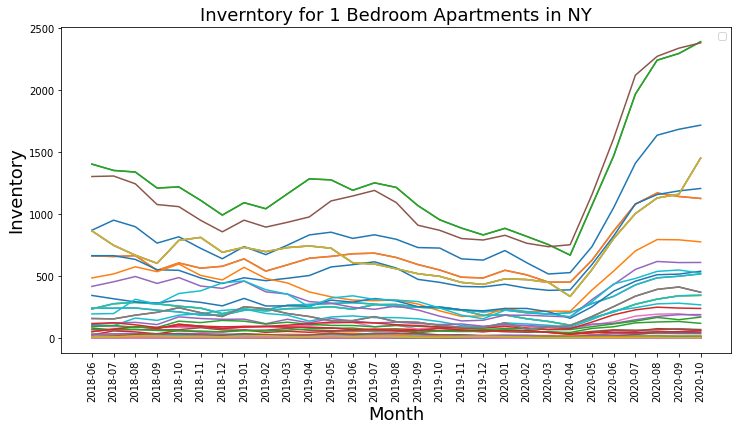

In [ ]:
view=inv_clean[inv_clean['bd']==1].sample(n = 50) 
plt.figure(figsize=(12,6) )
for row in range(len(view)):
  sns.lineplot(x=view.columns[2:],y=view.iloc[row,2:])
  plt.title('Inverntory for 1 Bedroom Apartments in NY',size=18)
  plt.xlabel('Month',size=18)
  plt.ylabel('Inventory',size=18)
  plt.xticks(view.columns[2:], view.columns[2:], rotation='vertical')
  # plt.legend(bbox_to_anchor=(1.05, 1))

plt.legend('')

plt.savefig('inventory1bd')

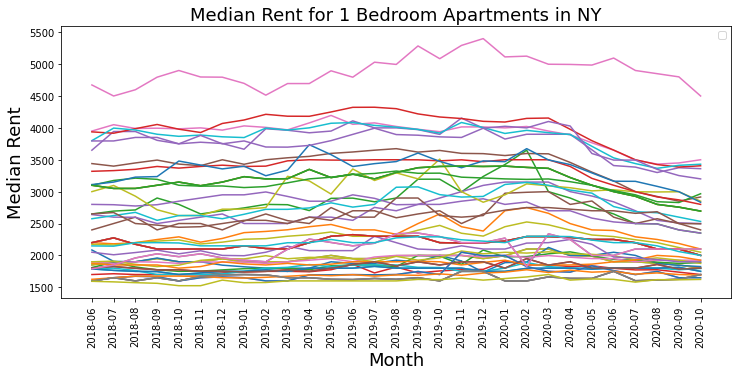

In [ ]:
view=rent_clean[rent_clean['bd']==1].sample(50)
plt.figure(figsize=(12,5))
for row in range(len(view)):
  sns.lineplot(x=view.columns[2:],y=view.iloc[row,2:])
  plt.title('Median Rent for 1 Bedroom Apartments in NY', size=18)
  plt.xlabel('Month',size=18)
  plt.ylabel('Median Rent',size=18)
  plt.xticks(view.columns[2:], view.columns[2:], rotation='vertical')
  # plt.legend(bbox_to_anchor=(1.05, 1))

plt.legend('')
plt.savefig('rent1bd')

In [ ]:
X_oct=rent_clean.iloc[:,2:-1]
Y_oct=rent_clean.iloc[:,-1:]

X_train, X_test, Y_train, Y_test = train_test_split(X_oct, Y_oct, test_size=0.20)

from sklearn.linear_model import Ridge
ridge1 = Ridge(alpha=1.0)
ridge1.fit(X_train,Y_train)
ridge1.coef_

array([[-0.06730771, -0.06409133,  0.08822872, -0.15163805,  0.18996098,
        -0.0298102 ,  0.15894233, -0.16482174, -0.01161756,  0.02937621,
         0.05701053, -0.05878789,  0.09078079, -0.07731476,  0.24938201,
        -0.37549561,  0.24054622, -0.06677651,  0.09299441, -0.12150956,
         0.06585968, -0.02071547, -0.00860448, -0.05026976,  0.10222132,
        -0.23567851,  0.31997039,  0.82267124]])

In [ ]:
X_Jan=rent_clean.iloc[:,2:-10]
Y_Jan=rent_clean.iloc[:,-10:-9]

X_train, X_test, Y_train, Y_test = train_test_split(X_oct, Y_oct, test_size=0.20)

from sklearn.linear_model import Ridge
ridge1 = Ridge(alpha=1.0)
ridge1.fit(X_train,Y_train)
ridge1.coef_

array([[-0.05157013, -0.07395439,  0.06668778, -0.0613648 ,  0.13549656,
        -0.05233217,  0.16835609, -0.14659345,  0.12117227, -0.08897424,
         0.12809942, -0.22038928,  0.12446023, -0.03139446,  0.08671398,
        -0.15354451,  0.14950968, -0.06685253,  0.02258533, -0.11177139,
         0.07001033, -0.00857223, -0.00893944, -0.04958062,  0.15178245,
        -0.11533958,  0.13645588,  0.8865438 ]])

### Collinearity 

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = combined_data.iloc[:,1:]

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
vif_data = vif_data.sort_values(by=['VIF'])
#pd.set_option('display.max_rows', None) #VIF above 5 is deemed as high collinearity


print(vif_data)

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                                              feature          VIF
1                                      prev_inventory     2.421355
45  median_year_structure_built__housing_units_med...     2.612601
5                      covid_rate_of_increase_prev_mo     2.713723
2                                    covid_%_positive     3.196076
0                                     prev_month_rent     3.695989
42  employment_status_for_the_population_16_years_...     4.401106
46  lower_contract_rent_quartile_(dollars)__renter...     5.378881
4                              covid_rate_of_increase     5.834858
51  median_gross_rent_as_a_percentage_of_household...     6.077687
52  lower_value_quartile_(dollars)__owner-occupied...     6.424511
38  sex_of_workers_by_means_of_transportation_to_w...     6.856371
53  median_value_(dollars)__owner-occupied_housing...     7.781900
61  tenure_occupied_housing_units_total_renter_occ...     8.802635
3                            covid_%_positive_prev_mo     8.91

# Baseline

In [63]:
baseline_data_rent_only = combined_data.copy()[['prev_month_rent','rent']]
baseline_data_rent_only

,prev_month_rent,rent
0,2834.0,2850.0
1,3872.0,3848.0
2,5800.0,5595.0
3,6708.0,7000.0
4,2850.0,2875.0
...,...,...
11335,2100.0,2125.0
11336,2950.0,2695.0
11337,1626.0,1699.0
11338,2125.0,2100.0


In [64]:
from sklearn import metrics

baseline_mse = mean_squared_error(baseline_data_rent_only['prev_month_rent'], baseline_data_rent_only['rent'])

print("MSE using previous month price: ", baseline_mse)

print("Mean Error (Magnitude): ", np.sqrt(baseline_mse))



MSE using previous month price:  60760.319269302374
Mean Error (Magnitude):  246.4960836794418


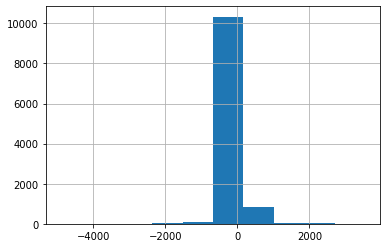

In [66]:
baseline_diff = baseline_data_rent_only['prev_month_rent'] - baseline_data_rent_only['rent']

# Model

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

n = 100
X = combined_data.iloc[:,1:]
Y = combined_data.iloc[:,0]
MSE_LR = np.empty([n, 1])

for i in range(100):
  X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.20)
  lr = LinearRegression().fit(X_train, Y_train)
  val = mean_squared_error(Y_test,lr.predict(X_test))
  MSE_LR[i] = val
  #print("MSE: ", mean_squared_error(Y_test,lr.predict(X_test)))
  #print("Mean Error (Magnitude): ", np.sqrt(mean_squared_error(Y_test,lr.predict(X_test))))
  
  feature_coefs = pd.DataFrame(zip(X_train.columns.tolist(), lr.coef_.tolist()),columns=['feature','coef'])
  #print("Feature Coefs: ")
  #print(feature_coefs.sort_values(by='coef',ascending=False).head(5))

print("Mean Square Error Average for 100 trials: ",MSE_LR.mean())
print("Mean Error Average for 100 trials: ", np.sqrt(MSE_LR.mean()))

print("Feature Coefs: ")
print(feature_coefs.sort_values(by='coef',ascending=False).head(20))

Mean Square Error Average for 100 trials:  59553.27176326487
Mean Error Average for 100 trials:  244.03539039095307
Feature Coefs: 
                                              feature       coef
5                      covid_rate_of_increase_prev_mo  56.815902
24                                            bd__3.0  38.756816
16                                           month_11  33.063298
6                                             month_1  25.872541
7                                             month_2  21.942899
19                                          year_2019  20.814971
61  tenure_occupied_housing_units_total_renter_occ...  17.570492
4                              covid_rate_of_increase  16.055489
13                                            month_8  14.091643
23                                            bd__2.0   9.481090
17                                           month_12   9.318167
14                                            month_9   9.266826
18                     

### LR with standardized values and PCA

In [52]:

X = combined_data.iloc[:,1:]
Y = combined_data.iloc[:,0]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [53]:
pca = PCA()
pca.fit(X_scaled)
sum(pca.explained_variance_ratio_[:40]) 
#5 components explain ~57.2% of variance
#15 components explain ~80.9% of variance
#30 components explain ~97.5% of variance
#40 components explains ~99.7% of variance

0.9946770008681347

In [ ]:
pca.set_params(n_components=40)
pca.fit(X_scaled)
X_pc = pca.transform(X_scaled)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X_pc, Y, test_size=0.20)

lr = LinearRegression().fit(X_train, Y_train)
print("MSE: ", mean_squared_error(Y_test,lr.predict(X_test)))
print("Mean Error (Magnitude): ", np.sqrt(mean_squared_error(Y_test,lr.predict(X_test))))

MSE:  56607.082980454405
Mean Error (Magnitude):  237.92243059546615


In [ ]:
feature_coefs = pd.DataFrame(zip(pd.DataFrame(X_train).columns.tolist(), lr.coef_.tolist()),columns=['feature','coef'])
print("Feature Coefs: ")
print(feature_coefs.sort_values(by='coef',ascending=False).head(10))

Feature Coefs: 
    feature        coef
32       32  998.037022
35       35  862.810199
6         6  632.970935
5         5  457.921282
7         7  405.117698
1         1  291.893978
8         8  239.333872
25       25  219.139142
0         0  205.552232
37       37  110.972218


In [ ]:
top_principal_components = feature_coefs.sort_values(by='coef',ascending=False).head(3)['feature'].values

for pc in top_principal_components:
  print("")
  print("top 5 features in principal components {number}: ".format(number=pc))
  print(pd.DataFrame(zip(X.columns.to_list(), pca.components_[pc])).sort_values(by=1,ascending=False).head(5))


top 5 features in principal components 32: 
                                                    0         1
0                                     prev_month_rent  0.546108
1                                      prev_inventory  0.260663
21                                            bd__0.0  0.194795
51  median_gross_rent_as_a_percentage_of_household...  0.164139
37  sex_of_workers_by_means_of_transportation_to_w...  0.150510

top 5 features in principal components 35: 
                                                    0         1
46  lower_contract_rent_quartile_(dollars)__renter...  0.500165
0                                     prev_month_rent  0.475272
38  sex_of_workers_by_means_of_transportation_to_w...  0.268539
1                                      prev_inventory  0.170845
21                                            bd__0.0  0.167721

top 5 features in principal components 6: 
                         0         1
24                 bd__3.0  0.490008
18               year_20

In [ ]:
# Repeat Experiment with 100 trials

MSE_PcLR = np.empty([n, 1])

for j in range(100):
  X_train, X_test, Y_train, Y_test = train_test_split( X_pc, Y, test_size=0.20)
  lr = LinearRegression().fit(X_train, Y_train)
  MSE_PcLR[j] = mean_squared_error(Y_test,lr.predict(X_test))
  #print("MSE: ", mean_squared_error(Y_test,lr.predict(X_test)))
  #print("Mean Error (Magnitude): ", np.sqrt(mean_squared_error(Y_test,lr.predict(X_test))))

print("Mean Square Error Average for 100 trials: ",MSE_PcLR.mean())
print("Mean Error Average for 100 trials: ", np.sqrt(MSE_PcLR.mean()))

Mean Square Error Average for 100 trials:  59079.22472575587
Mean Error Average for 100 trials:  243.06218283755265


### Decision Tree Prediction

In [ ]:


N = 100
MSE_DT = np.empty([N, 1])

for i in range(N):
  DT_model = DecisionTreeRegressor(random_state = i)
  X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 101)
  DT_model.fit(X_train, Y_train)
  DT_result = DT_model.predict(X_test)
  MSE_DT[i] = mean_squared_error(Y_test, DT_result)


print("Mean Square Error Average for 100 trials: ", MSE_DT.mean())
print("Mean Square Error Average for 100 trials: ", np.sqrt(MSE_DT.mean()))

Mean Square Error Average for 100 trials:  75124.45228765554
Mean Square Error Average for 100 trials:  274.0884023224178


### Decision Tree with PCA

In [ ]:


N = 100
MSE_DT_PCA = np.empty([N, 1])

for i in range(N):
  DT_model_PCA = DecisionTreeRegressor(random_state = i)
  X_train, X_test, Y_train, Y_test = train_test_split(X_pc,Y,test_size = 0.2, random_state = 101)
  DT_model_PCA.fit(X_train, Y_train)
  DT_result_PCA = DT_model_PCA.predict(X_test)
  MSE_DT_PCA[i] = mean_squared_error(Y_test, DT_result_PCA)


print("Mean Square Error Average for 100 trials: ", MSE_DT_PCA.mean())
print("Mean Square Error Average for 100 trials: ", np.sqrt(MSE_DT_PCA.mean()))

Mean Square Error Average for 100 trials:  196175.557962075
Mean Square Error Average for 100 trials:  442.91710055277275


### Gradient Boosted Model (GBM)

In [ ]:


N = 5
MSE_GBM = np.empty([N, 1])

for i in range(N):
  X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = i)
  GBM_reg = ensemble.GradientBoostingRegressor()
  GBM_reg.fit(X_train, Y_train)
  GBM_result = GBM_reg.predict(X_test)
  MSE_GBM[i] = mean_squared_error(Y_test, GBM_result)


print("Mean Square Error Average for 100 trials: ", MSE_GBM.mean())
print("Mean Square Error Average for 100 trials: ", np.sqrt(MSE_GBM.mean()))


Mean Square Error Average for 100 trials:  46747.52995996709
Mean Square Error Average for 100 trials:  216.21177109483907


### Gradient Boosted Model with PCA

In [ ]:


N = 5
MSE_GBM_PCA = np.empty([N, 1])

for i in range(N):
  X_train, X_test, Y_train, Y_test = train_test_split(X_pc,Y,test_size = 0.2, random_state = i)
  GBM_reg_PCA = ensemble.GradientBoostingRegressor()
  GBM_reg_PCA.fit(X_train, Y_train)
  GBM_result_PCA = GBM_reg_PCA.predict(X_test)
  MSE_GBM_PCA[i] = mean_squared_error(Y_test, GBM_result_PCA)


print("Mean Square Error Average for 100 trials: ", MSE_GBM_PCA.mean())
print("Mean Square Error Average for 100 trials: ", np.sqrt(MSE_GBM_PCA.mean()))

Mean Square Error Average for 100 trials:  155309.27496007568
Mean Square Error Average for 100 trials:  394.09297755742324


### Random Forest (RF)

In [ ]:


N = 5
MSE_RF = np.empty([N, 1])
X=combined_data.iloc[:,1:]
Y=combined_data.iloc[:,0]

for i in range(N):
  X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = i)
  RF = RandomForestRegressor()
  RF.fit(X_train, Y_train)
  RF_result = RF.predict(X_test)
  MSE_RF[i] = mean_squared_error(Y_test, RF_result)

# print(MSE_RF)
print("Mean Square Error Average for 100 trials: ", MSE_RF.mean())
print("Mean Error Average for 100 trials: ", np.sqrt(MSE_RF.mean()))

Mean Square Error Average for 100 trials:  42146.102195959
Mean Error Average for 100 trials:  205.29515872508782


### Random Forest (RF) Fine Tuning 

In [ ]:
X=combined_data.iloc[:,1:]
Y=combined_data.iloc[:,0]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

In [ ]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10,20,30,40,50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10,20,30,40,50]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }
print(random_grid)


{'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [5, 10, 20, 30, 40, 50], 'min_samples_leaf': [5, 10, 20, 30, 40, 50], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available core
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 55}

In [ ]:
MAE_rf_tuned=[]
for i in range(50):
  X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.20)
  rf_tuned=RandomForestRegressor(bootstrap=True,max_depth=100,max_features='auto',min_samples_leaf=5,min_samples_split=10,n_estimators=55)
  rf_tuned.fit(X_train, Y_train)
  MAE_rf_tuned.append(mean_absolute_error(Y_test,rf_tuned.predict(X_test)))

In [ ]:
np.array(MAE_rf_tuned).mean()

96.5410542521124

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.20)

In [ ]:
rf_tuned=RandomForestRegressor(bootstrap=True,max_depth=100,max_features='auto',min_samples_leaf=5,min_samples_split=10,n_estimators=55)
rf_tuned.fit(X_train, Y_train)
mean_absolute_error(Y_test,rf_tuned.predict(X_test))

91.47777951663379

### Random Forest with PCA

In [ ]:

N = 5
MSE_RF_PCA = np.empty([N, 1])

for i in range(N):
  X_train, X_test, Y_train, Y_test = train_test_split(X_pc,Y,test_size = 0.2, random_state = 0)
  RF_PCA = RandomForestRegressor()
  RF_PCA.fit(X_train, Y_train)
  RF_result_PCA = RF_PCA.predict(X_test)
  MSE_RF_PCA[i] = mean_squared_error(Y_test, RF_result_PCA)


print("Mean Square Error Average for 100 trials: ", MSE_RF_PCA.mean())
print("Mean Error Average for 100 trials: ", np.sqrt(MSE_RF_PCA.mean()))

Mean Square Error Average for 100 trials:  82129.95395239959
Mean Error Average for 100 trials:  286.5832408784568


### KNN

In [ ]:


N = 5
NN = 20 
MSE_KNN = np.empty([N, NN])
X=combined_data.iloc[:,1:]
Y=combined_data.iloc[:,0]


for k in range(NN):
  for i in range(N):
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)
    KNN = KNeighborsRegressor(n_neighbors = k+1)
    KNN.fit(X_train, Y_train)
    KNN_result = KNN.predict(X_test)
    MSE_KNN[i][k] = mean_squared_error(Y_test, KNN_result)

print("Mean Square Error Average for 100 trials: ", MSE_KNN.mean())
print("Mean Error Average for 100 trials: ", np.sqrt(MSE_KNN.mean()))
MSE_KNN.mean(axis=0)


Mean Square Error Average for 100 trials:  81580.53923359442
Mean Error Average for 100 trials:  285.62307195602114


array([122855.29678131,  88932.41751038,  74777.84634379,  65325.91824884,
        73669.6987466 ,  76860.16695653,  72749.99148118,  60278.65381733,
        72452.8610844 ,  64485.19958845,  85422.98079928,  74373.5672751 ,
        74776.04102512,  89332.78080881,  83540.10979846,  83695.21950975,
        92333.91729594,  81263.51737295, 102548.8881531 ,  91935.71207456])

Mean Square Error Average for 100 trials:  60278.6538173298
Mean Error Average for 100 trials:  245.51711512098257


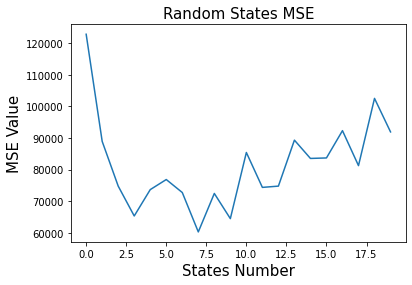

In [ ]:
# plot about different neighbours

MSE_KNN_mean = MSE_KNN.mean(axis=0)

plt.plot(MSE_KNN_mean)
plt.title('Random States MSE', size=15)
plt.xlabel('States Number',size=15)
plt.ylabel('MSE Value',size=15)

best_MSE = MSE_KNN_mean.min()

print("Mean Square Error Average for 100 trials: ", best_MSE)
print("Mean Error Average for 100 trials: ", np.sqrt(best_MSE))

### KNN with PCA

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

N = 100
MSE_KNN_PCA = np.empty([N, 1])

for i in range(N):
  X_train, X_test, Y_train, Y_test = train_test_split(X_pc,Y,test_size = 0.2, random_state = 0)
  KNN_PCA = KNeighborsRegressor(n_neighbors=10)
  KNN_PCA.fit(X_train, Y_train)
  KNN_result_PCA = KNN_PCA.predict(X_test)
  MSE_KNN_PCA[i] = mean_squared_error(Y_test, KNN_result_PCA)


print("Mean Square Error Average for 100 trials: ", MSE_KNN_PCA.mean())
print("Mean Error Average for 100 trials: ", np.sqrt(MSE_KNN_PCA.mean()))

Mean Square Error Average for 100 trials:  337540.64597880526
Mean Error Average for 100 trials:  580.9824833665859


# Model Evaluation 

In [ ]:
baseline_mae = mean_absolute_error(baseline_data_rent_only['prev_month_rent'], baseline_data_rent_only['rent'])

In [ ]:
n = 50
X = combined_data.iloc[:,[1,2,6,43,46]]
# X = combined_data.iloc[:,1:]
Y = combined_data.iloc[:,0]

MAE_LR = []
MAE_DT = []
MAE_GBM = []
MAE_RF = []
MAE_KNN = []

for i in range(50):
  X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.20,random_state=i)
  lr = LinearRegression().fit(X_train, Y_train)
  MAE_LR.append(mean_absolute_error(Y_test,lr.predict(X_test)))

  DT_model = DecisionTreeRegressor()
  DT_model.fit(X_train, Y_train)
  MAE_DT.append(mean_absolute_error(Y_test,DT_model.predict(X_test)))

  GBM_reg = ensemble.GradientBoostingRegressor()
  GBM_reg.fit(X_train, Y_train)
  MAE_GBM.append(mean_absolute_error(Y_test, GBM_reg.predict(X_test)))

  RF = RandomForestRegressor()
  RF.fit(X_train, Y_train)
  MAE_RF.append(mean_absolute_error(Y_test,RF.predict(X_test)))

  KNN = KNeighborsRegressor(n_neighbors = 5)
  KNN.fit(X_train, Y_train)
  KNN_result = KNN.predict(X_test)
  MAE_KNN.append(mean_absolute_error(Y_test, KNN_result))


In [ ]:
MAE=pd.DataFrame(np.arange(1,51),columns=['trial_number'])
MAE['Baseline']=np.repeat(baseline_mae,50)
MAE['Linear Regression']=MAE_LR
MAE['Decision Tree']=MAE_DT
MAE['Gradient Boosted Tree']=MAE_GBM
MAE['Random Forest']=MAE_RF
MAE['K Nearest Neighbors']=MAE_KNN
MAE=MAE.set_index('trial_number')

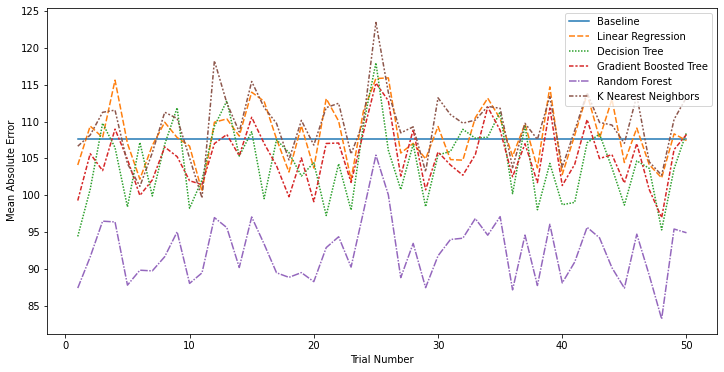

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=MAE)
plt.xlabel('Trial Number')
plt.ylabel('Mean Absolute Error')
plt.legend(loc="upper right")
plt.show()
plt.savefig('eval')

In [ ]:
MAE.mean().sort_values()

Random Forest             92.398417
Decision Tree            104.431914
Gradient Boosted Tree    105.180023
Baseline                 107.562228
Linear Regression        108.209373
K Nearest Neighbors      109.429449
dtype: float64

# Prediction of Next Month Rent

In [100]:
combined_data.head(5)

,rent,prev_month_rent,prev_inventory,covid_%_positive,covid_%_positive_prev_mo,covid_rate_of_increase,covid_rate_of_increase_prev_mo,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2018,year_2019,year_2020,bd__0.0,bd__1.0,bd__2.0,bd__3.0,sex_by_age__total_population_total,sex_by_age_total_population_total_male,sex_by_age_total_population_total_female,"sex_by_age_(white_alone,_not_hispanic_or_latino)__white_alone,_not_hispanic_or_latino_population_total",sex_by_age_(hispanic_or_latino)__hispanic_or_latino_population_total,race__total_population_total,race_total_population_total_white_alone,race_total_population_total_black_or_african_american_alone,race_total_population_total_asian_alone,sex_of_workers_by_means_of_transportation_to_work__workers_16_years_and_over_total,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_car_truck_or_van,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_public_transportation_(excluding_taxicab),sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_public_transportation_(excluding_taxicab)_subway_or_elevated,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_bicycle,sex_of_workers_by_means_of_transportation_to_work_workers_16_years_and_over_total_walked,aggregate_travel_time_to_work_(in_minutes)_of_workers_by_sex__workers_16_years_and_over_who_did_not_work_at_home_aggregate_travel_time_to_work_(in_minutes),household_income_in_the_past_12_months_(in_2018_inflation-adjusted_dollars)__households_total,employment_status_for_the_population_16_years_and_over_population_16_years_and_over_total_in_labor_force_civilian_labor_force_unemployed,housing_units__housing_units_total,median_gross_rent_by_bedrooms_renter-occupied_housing_units_paying_cash_rent_median_gross_rent_total,median_year_structure_built__housing_units_median_year_structure_built,lower_contract_rent_quartile_(dollars)__renter-occupied_housing_units_paying_cash_rent_lower_contract_rent_quartile,median_contract_rent_(dollars)__renter-occupied_housing_units_paying_cash_rent_median_contract_rent,upper_contract_rent_quartile_(dollars)__renter-occupied_housing_units_paying_cash_rent_upper_contract_rent_quartile,contract_rent_renter-occupied_housing_units_total_with_cash_rent,median_gross_rent_(dollars)__renter-occupied_housing_units_paying_cash_rent_median_gross_rent,median_gross_rent_as_a_percentage_of_household_income_in_the_past_12_months_(dollars)__renter-occupied_housing_units_paying_cash_rent_median_gross_rent_as_a_percentage_of_household_income,lower_value_quartile_(dollars)__owner-occupied_housing_units_lower_value_quartile_(dollars),median_value_(dollars)__owner-occupied_housing_units_median_value_(dollars),upper_value_quartile_(dollars)__owner-occupied_housing_units_upper_value_quartile_(dollars),median_household_income_the_past_12_months_(in_2018_inflation-adjusted_dollars)_by_tenure_occupied_housing_units_median_household_income_in_the_past_12_months_(in_2018_inflation-adjusted_dollars)_total,median_household_income_the_past_12_months_(in_2018_inflation-adjusted_dollars)_by_tenure_occupied_housing_units_median_household_income_in_the_past_12_months_(in_2018_inflation-adjusted_dollars)_renter_occupied_(dollars),tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_0.50_or_less_occupants_per_room,tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_0.51_to_1.00_occupants_per_room,tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_1.01_to_1.50_occupants_per_room,tenure_by_occupants_per_room_occupied_housing_units_total_renter_occupied_1.51_to_2.00_occupants_per_room,tenure_occupied_housing_units_total_renter_occupied
0,2850.0,2834.0,262.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,22924,11671,11253,12182.0,3246.0,22924,14422,1413,5774,14265.0,582.0,7084.0,6256.0,534.0,4595.0,27.916604,12431

In [514]:
df_predictive = combined_data.iloc[:,[0]]
df_predictive [["inventory"]] = cpy.iloc[:,[10]]
df_predictive[["covid_%_positive","employment","median_year"]] = combined_data.iloc[:,[3,43,46]]
df_predictive.head(5)

combined_data_timestamp = cpy['timestamp']
combined_data_bd = cpy['bd']
combined_data_zipcodes = cpy['zipcode']
combined_data_prev_month_rent = cpy['prev_month_rent']

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [520]:
# time_filter 
time_filter = combined_data_timestamp <= '2020-09-01' #filter for prior to Sep 2020

# bedroom filter 
bd_filter = combined_data_bd == 1

X = combined_data.iloc[:,[1,2,6,43,46]]
Y = combined_data.iloc[:,0]

X_train = X[time_filter]
Y_train = Y[time_filter]

X_test = X[~time_filter]
Y_test = Y[~time_filter]

n = 50

lr = LinearRegression().fit(X_train, Y_train) #train model with data prior or during Sep 2020
lr_result = lr.predict(X_test)#predict Oct 2020

DT_model = DecisionTreeRegressor()
DT_model.fit(X_train, Y_train)
DT_result = DT_model.predict(X_test)

GBM_reg = ensemble.GradientBoostingRegressor()
GBM_reg.fit(X_train, Y_train)
GBM_result = GBM_reg.predict(X_test)

RF = RandomForestRegressor()
RF.fit(X_train, Y_train)
RF_result = RF.predict(X_test)

KNN = KNeighborsRegressor(n_neighbors = 5)
KNN.fit(X_train, Y_train)
KNN_result = KNN.predict(X_test)


In [521]:
graph_preds = pd.DataFrame(combined_data_zipcodes[~time_filter])

graph_preds.zipcode = graph_preds.zipcode.astype(str)
graph_preds['bd'] = combined_data_bd[~time_filter]
graph_preds['preds'] = RF_result
graph_preds['actual'] = Y_test
graph_preds = graph_preds[bd_filter]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [522]:
Y_test

10935    1695.0
10936    2008.0
10937    2295.0
10938    1700.0
10939    2113.0
          ...  
11335    2125.0
11336    2695.0
11337    1699.0
11338    2100.0
11339    2760.0
Name: rent, Length: 405, dtype: float64

In [378]:
import folium
zipcodes_json = '/content/drive/MyDrive/HJLS_Properties/DS_Data/nyc-zip-code-tabulation-areas-polygons.geojson'

In [523]:
NYC_map = folium.Map(location=[40.730610,-73.935242],zoom_start=10)

folium.Choropleth(geo_data=zipcodes_json,
                  data=graph_preds,
                  columns=['zipcode','actual'],
                  key_on='feature.properties.postalCode',
                  fill_color='YlOrRd',
                  nan_fill_color='gray').add_to(NYC_map)

NYC_map

In [525]:
NYC_map = folium.Map(location=[40.730610,-73.935242],zoom_start=10)

folium.Choropleth(geo_data=zipcodes_json,
                  data=graph_preds,
                  columns=['zipcode','preds'],
                  key_on='feature.properties.postalCode',
                  fill_color='YlOrRd',
                  nan_fill_color='gray').add_to(NYC_map)

NYC_map

In [512]:
NYC_map.save('/content/drive/MyDrive/HJLS_Properties/DS_Data/prediction_map.html')

In [103]:
n = 50
X = combined_data.iloc[:,[1,2,6,43,46]]
# X = combined_data.iloc[:,1:]
Y = combined_data.iloc[:,0]

i = 48
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.20,random_state=i)
lr = LinearRegression().fit(X_train, Y_train) #train model with data prior to Sep 2020
lr_result = lr.predict(df_predictive.iloc[10935:,:])#use Oct 2020 data to predict Nov 2020 rent


DT_model = DecisionTreeRegressor()
DT_model.fit(X_train, Y_train)
DT_result = DT_model.predict(df_predictive.iloc[10935:,:])

GBM_reg = ensemble.GradientBoostingRegressor()
GBM_reg.fit(X_train, Y_train)
GBM_result = GBM_reg.predict(df_predictive.iloc[10935:,:])

RF = RandomForestRegressor()
RF.fit(X_train, Y_train)
RF_result = RF.predict(df_predictive.iloc[10935:,:])

KNN = KNeighborsRegressor(n_neighbors = 5)
KNN.fit(X_train, Y_train)
KNN_result = KNN.predict(df_predictive.iloc[10935:,:])

In [106]:
df_predictive.iloc[10935:,:]

,rent,inventory,covid_%_positive,employment,median_year
10935,1695.0,539.0,0.00,0.094275,1962.0
10936,2008.0,802.0,0.00,0.094275,1962.0
10937,2295.0,466.0,0.00,0.094275,1962.0
10938,1700.0,225.0,0.00,0.094275,1962.0
10939,2113.0,199.0,0.00,0.094275,1962.0
...,...,...,...,...,...
11335,2125.0,11.0,7.29,0.047919,1978.0
11336,2695.0,12.0,7.29,0.047919,1978.0
11337,1699.0,16.0,6.75,0.047919,1978.0
11338,2100.0,11.0,6.75,0.047919,1978.0


In [ ]:
n = 50
# X = combined_data.iloc[:10934,[1,2,6,43,46]]
X = combined_data.iloc[:10934,1:]
Y = combined_data.iloc[:10934,0]

MAE_LR_pred = []
MAE_DT_pred = []
MAE_GBM_pred = []
MAE_RF_pred = []
MAE_KNN_pred = []

i = 48
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.20,random_state=i)
lr = LinearRegression().fit(X_train, Y_train) #train model with data prior to Sep 2020
lr_result = lr.predict(combined_data.iloc[10935:,1:])#use Sep 2020 data to predict Oct 2020 rent
# lr_result_Oct20 = lr_result[10935:]
# lr_result_Sep20 = lr_result[10530:10934]
MAE_LR_pred.append(mean_absolute_error(combined_data.iloc[10935:,0],lr_result))#compare result with Oct 2020 rent
print(MAE_LR_pred)

DT_model = DecisionTreeRegressor()
DT_model.fit(X_train, Y_train)
# DT_result = DT_model.predict(df_predictive)
# DT_result_Sep20 = DT_result[10530:10934]
DT_result = DT_model.predict(combined_data.iloc[10935:,1:])
MAE_DT_pred.append(mean_absolute_error(combined_data.iloc[10935:,0],DT_result))
print(MAE_DT_pred)

GBM_reg = ensemble.GradientBoostingRegressor()
GBM_reg.fit(X_train, Y_train)
# GBM_result = GBM_reg.predict(df_predictive)
# GBM_result_Sep20 = GBM_result[10530:10934]
GBM_result = GBM_reg.predict(combined_data.iloc[10935:,1:])
MAE_GBM_pred.append(mean_absolute_error(combined_data.iloc[10935:,0],GBM_result))
print(MAE_GBM_pred)

RF = RandomForestRegressor()
RF.fit(X_train, Y_train)
# RF_result = RF.predict(df_predictive)
# RF_result_Sep20 = RF_result[10530:10934]
RF_result = RF.predict(combined_data.iloc[10935:,1:])
MAE_RF_pred.append(mean_absolute_error(combined_data.iloc[10935:,0],RF_result))
print(MAE_RF_pred)

KNN = KNeighborsRegressor(n_neighbors = 5)
KNN.fit(X_train, Y_train)
# KNN_result = KNN.predict(df_predictive)
# KNN_result_Sep20 = KNN_result[10530:10934]
KNN_result = KNN.predict(combined_data.iloc[10935:,1:])
MAE_KNN_pred.append(mean_absolute_error(combined_data.iloc[10935:,0],KNN_result))
print(MAE_KNN_pred)

[100.14984763835535]
[130.86543209876544]
[88.2068707321803]
[97.1716049382716]
[238.8350617283951]


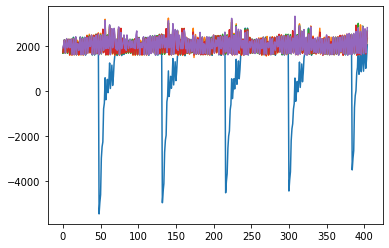

In [ ]:
plt.plot(lr_result)
plt.plot(DT_result)
plt.plot(GBM_result)
plt.plot(RF_result)
plt.plot(KNN_result)

In [ ]:
print(len(lr_result))
print(len(lr_result_Oct20))

11340
405


# Random Forest Analysis

In [55]:
X=combined_data.iloc[:,1:]
Y=combined_data.iloc[:,0]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 1)
RF = RandomForestRegressor()
RF.fit(X_train, Y_train)
RF_result = RF.predict(X_test)
mean_absolute_error(Y_test, RF_result)

89.47447641093476

In [61]:
difference=pd.DataFrame(RF_result-Y_test)

In [94]:
# Compare differences between RF and baseline 
compare_to_baseline = pd.merge(difference,pd.DataFrame(baseline_diff),how='left',left_index=True,right_index=True)
compare_to_baseline.columns = ['RF','Baseline']
compare_to_baseline = np.abs(compare_to_baseline)

compare_to_baseline['error_diff'] = compare_to_baseline['RF'] - compare_to_baseline['Baseline'] 

pd.cut(compare_to_baseline[compare_to_baseline['error_diff'] < 0]['error_diff'],bins=[-1000,-100,-50,-25,0]).value_counts()

(-25, 0]         547
(-50, -25]       343
(-100, -50]      252
(-1000, -100]    174
Name: error_diff, dtype: int64

In [79]:
np.abs(compare_to_baseline)

,RF,Baseline
5104,47.150000,37.0
5799,197.101667,150.0
537,39.238333,125.0
10270,0.995000,50.0
9015,11.300000,0.0
...,...,...
4920,4.090000,15.0
7933,156.498333,200.0
6737,20.220000,48.0
3497,87.685000,100.0


In [ ]:
bd3=X_test[X_test['bd__3.0']==1].index.tolist()
bd2=X_test[X_test['bd__2.0']==1].index.tolist()
bd1=X_test[X_test['bd__1.0']==1].index.tolist()
bdstud=X_test[X_test['bd__0.0']==1].index.tolist()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

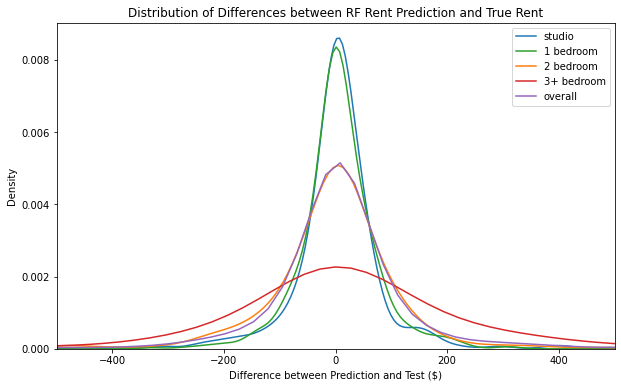

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(difference[difference.index.isin(bdstud)],color='C0',hist=False,label='studio')
sns.distplot(difference[difference.index.isin(bd1)],color='C2',hist=False,label='1 bedroom')
sns.distplot(difference[difference.index.isin(bd2)],color='C1',hist=False,label='2 bedroom')
sns.distplot(difference[difference.index.isin(bd3)],color='C3',hist=False,label='3+ bedroom')
sns.distplot(difference,color='C4',hist=False,label='overall')
plt.xlabel('Difference between Prediction and Test ($)')
plt.xlim(-500,500)
plt.title('Distribution of Differences between RF Rent Prediction and True Rent')
plt.legend()
plt.show()
